In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/market-price-of-onion-2020/Onion Prices 2020.csv


# Objective:
## 1) To get the modal price of onion for each month for the Mumbai market 
## 2) To build time series model and check the performance of the model using RMSE
## 3) To plot ACF and PACF plots
## 4) To perform Exponential smoothing using Holt-Winter’s technique and to forecast onion price for Mumbai market

In [2]:
#import required basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15,20]
import itertools

In [3]:
filename="/kaggle/input/market-price-of-onion-2020/Onion Prices 2020.csv"
df = pd.read_csv(filename)
df.head()

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price
0,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,03/01/2020,1350,4390,3100.0
1,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,04/01/2020,1390,4400,3200.0
2,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,06/01/2020,1460,5150,4310.0
3,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,07/01/2020,2010,5200,4200.0
4,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,10/01/2020,1320,4050,3300.0


In [4]:
df.shape

(107295, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107295 entries, 0 to 107294
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   state         107295 non-null  object 
 1   district      107295 non-null  object 
 2   market        107295 non-null  object 
 3   commodity     107295 non-null  object 
 4   variety       107295 non-null  object 
 5   arrival_date  107295 non-null  object 
 6   min_price     107295 non-null  int64  
 7   max_price     107295 non-null  int64  
 8   modal_price   107295 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 7.4+ MB


In [6]:
# Changing the date column to a Time Interval columnn
df.arrival_date = pd.DatetimeIndex(df.arrival_date)
df.dtypes

state                   object
district                object
market                  object
commodity               object
variety                 object
arrival_date    datetime64[ns]
min_price                int64
max_price                int64
modal_price            float64
dtype: object

In [7]:
pd.unique(df.district), pd.unique(df.state), pd.unique(df.market)

(array(['Kurnool', 'Bilaspur', 'Durg', 'Raigarh', 'Rajnandgaon',
        'North Goa', 'Ahmedabad', 'Amreli', 'Anand', 'Banaskanth',
        'Bharuch', 'Bhavnagar', 'Dahod', 'Jamnagar', 'Junagarh', 'Kheda',
        'Mehsana', 'Navsari', 'Panchmahals', 'Porbandar', 'Rajkot',
        'Surat', 'Surendranagar', 'Vadodara(Baroda)', 'Ambala', 'Bhiwani',
        'Faridabad', 'Fatehabad', 'Gurgaon', 'Hissar', 'Jhajar', 'Jind',
        'Kaithal', 'Karnal', 'Kurukshetra', 'Mahendragarh-Narnaul',
        'Mewat', 'Palwal', 'Panchkula', 'Panipat', 'Rewari', 'Rohtak',
        'Sirsa', 'Sonipat', 'Yamuna Nagar', 'Chamba', 'Hamirpur', 'Kangra',
        'Kullu', 'Mandi', 'Shimla', 'Sirmore', 'Solan', 'Una', 'Anantnag',
        'Jammu', 'Kathua', 'Rajouri', 'Srinagar', 'Udhampur', 'Lohardaga',
        'Ranchi', 'Bagalkot', 'Bangalore', 'Belgaum', 'Bellary', 'Bidar',
        'Bijapur', 'Chamrajnagar', 'Chikmagalur', 'Davangere', 'Dharwad',
        'Gadag', 'Hassan', 'Haveri', 'Kolar', 'Mandya',
        '

In [8]:
# change the index to date column
df.set_index('arrival_date', inplace=True)
#df.index = pd.PeriodIndex(df.arrival_date, freq="M")
df.head()

,state,district,market,commodity,variety,min_price,max_price,modal_price
arrival_date,,,,,,,,
2020-03-01,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,1350,4390,3100.0
2020-04-01,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,1390,4400,3200.0
2020-06-01,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,1460,5150,4310.0
2020-07-01,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,2010,5200,4200.0
2020-10-01,Andhra Pradesh,Kurnool,Kurnool,Onion,Local,1320,4050,3300.0


In [9]:
df = df.sort_values(by="arrival_date")
df.head()

,state,district,market,commodity,variety,min_price,max_price,modal_price
arrival_date,,,,,,,,
2020-01-01,Gujarat,Rajkot,Rajkot(Ghee Peeth),Onion,Onion,1255,5000,3750.0
2020-01-01,Kerala,Kottayam,Pala,Onion,Big,7500,8000,7700.0
2020-01-01,Karnataka,Gadag,Gadag,Onion,Other,300,1500,600.0
2020-01-01,Maharashtra,Nashik,Chandvad,Onion,Red,1000,4516,3800.0
2020-01-01,Punjab,Fatehgarh,Bassi Pathana,Onion,Onion,5000,9000,7000.0


In [10]:
df2020_mum = df[(df.district =="Mumbai")]
df2020_mum.head()

,state,district,market,commodity,variety,min_price,max_price,modal_price
arrival_date,,,,,,,,
2020-01-01,Maharashtra,Mumbai,Vashi New Mumbai,Onion,Other,4500,6500,5500.0
2020-01-02,Maharashtra,Mumbai,Vashi New Mumbai,Onion,Other,2400,3200,2800.0
2020-01-04,Maharashtra,Mumbai,Vashi New Mumbai,Onion,Other,1300,1800,1550.0
2020-01-13,Maharashtra,Mumbai,Vashi New Mumbai,Onion,Other,2800,3200,3000.0
2020-01-14,Maharashtra,Mumbai,Vashi New Mumbai,Onion,Other,2800,3800,3300.0


In [11]:
df2020_mum.shape

(93, 8)

In [12]:
# for easy undersatnding the numbers in describe function, we set precision to 0
pd.set_option("precision", 0)
df2020_mum.describe()

,min_price,max_price,modal_price
count,93,93,93
mean,1929,2670,2296
std,985,1225,1093
min,400,1000,750
25%,1400,1900,1700
50%,1600,2300,2000
75%,2600,3200,2900
max,4500,6500,5500


In [13]:
df2020_mum.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-04', '2020-01-13',
               '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-18', '2020-01-20', '2020-01-22', '2020-01-23',
               '2020-01-24', '2020-01-25', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-03', '2020-02-04', '2020-02-09', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-17', '2020-02-18',
               '2020-02-20', '2020-02-22', '2020-02-24', '2020-02-25',
               '2020-02-27', '2020-02-28', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-07', '2020-03-09',
               '2020-03-13', '2020-03-14', '2020-03-16', '2020-03-17',
               '2020-03-18', '2020-03-19', '2020-03-20', '2020-04-01',
               '2020-04-02', '2020-04-05', '2020-04-09', '2020-05-02',
               '2020-05-03', '2020-05-05', '2020-05-09', '2020-05-27',
      

In [14]:
df2020_mum = df2020_mum.drop(["state","district","market","commodity","variety","min_price","max_price"], axis=1)
df2020_mum.head()

,modal_price
arrival_date,
2020-01-01,5500
2020-01-02,2800
2020-01-04,1550
2020-01-13,3000
2020-01-14,3300


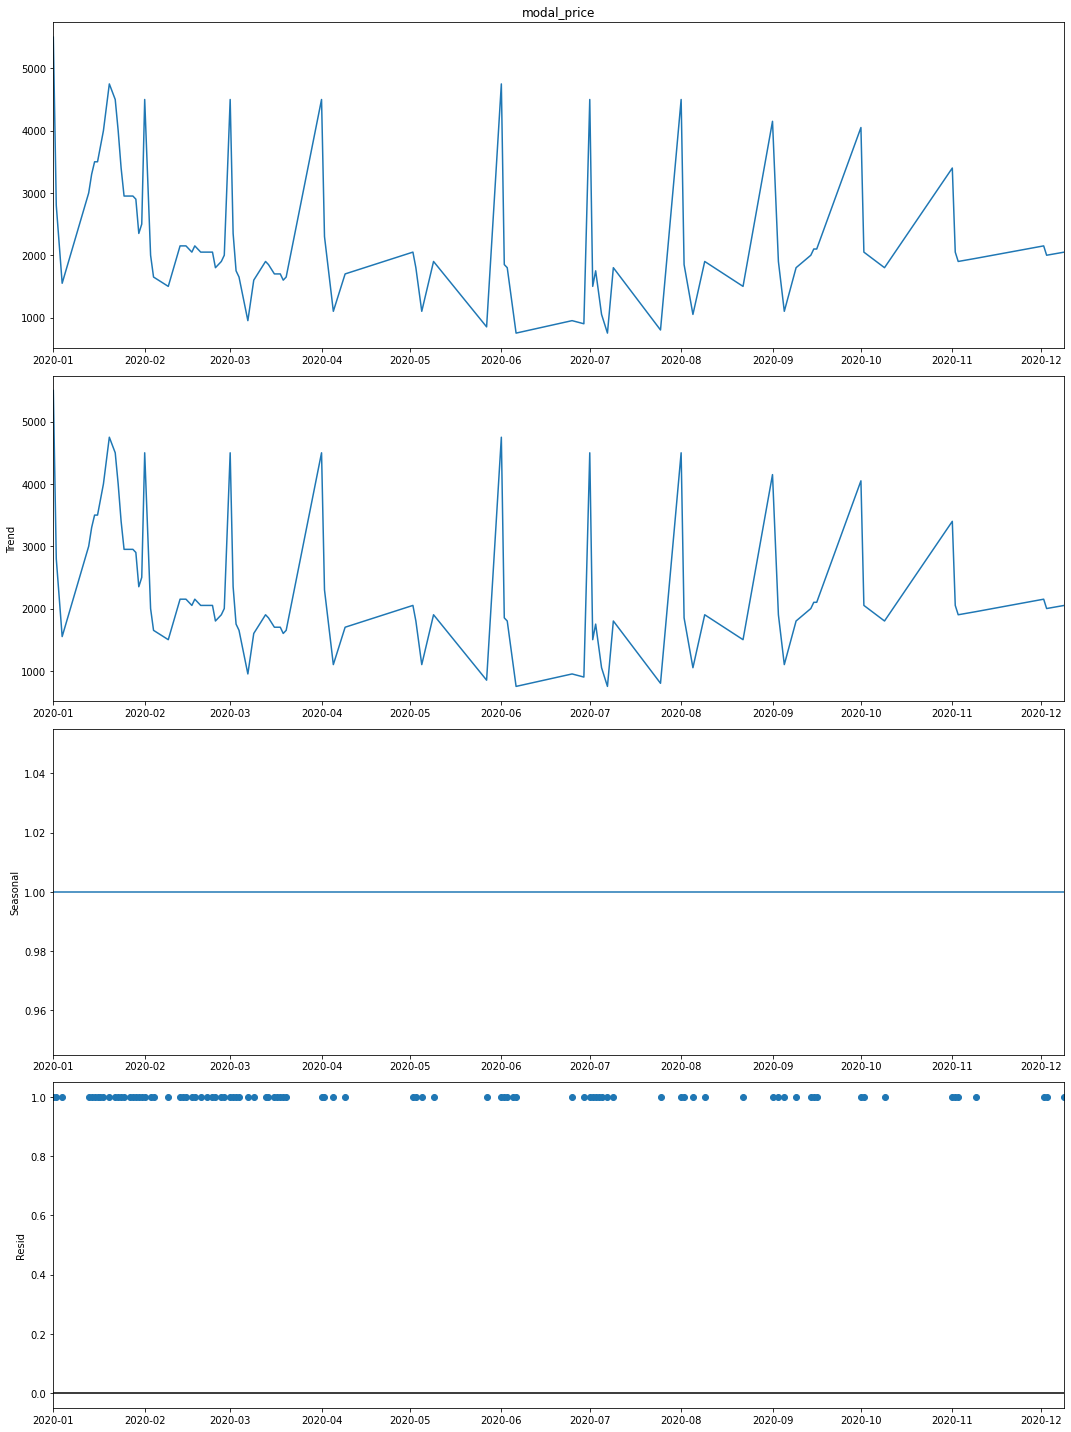

In [15]:
# Decompose the data frame to get the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df2020_mum['modal_price'],model='multiplicative',period=1)
decompose_result.plot()
plt.show()

# Modal price of onion for each month for the Mumbai market 

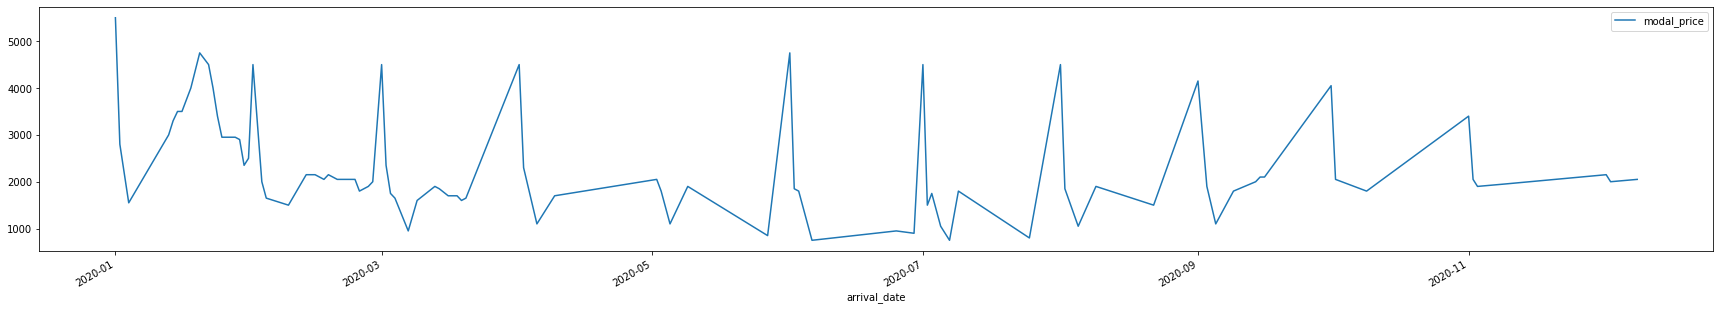

In [16]:
df2020_mum.plot(kind="line", y=["modal_price"],figsize=[30,5])
plt.show()

<AxesSubplot:ylabel='Frequency'>

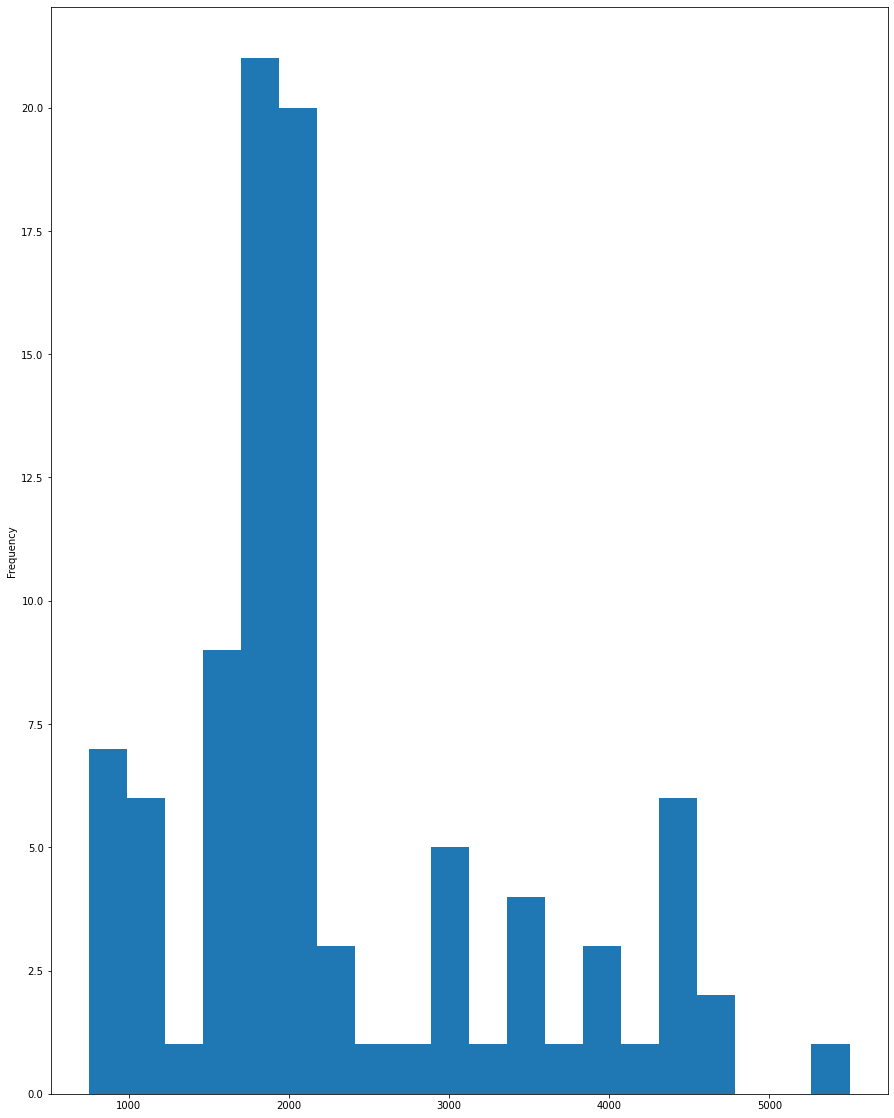

In [17]:
#Log-transformations can help to stabilize the variance of a time series
df2020_mum.modal_price.plot(kind="hist", bins=20)

<AxesSubplot:ylabel='Frequency'>

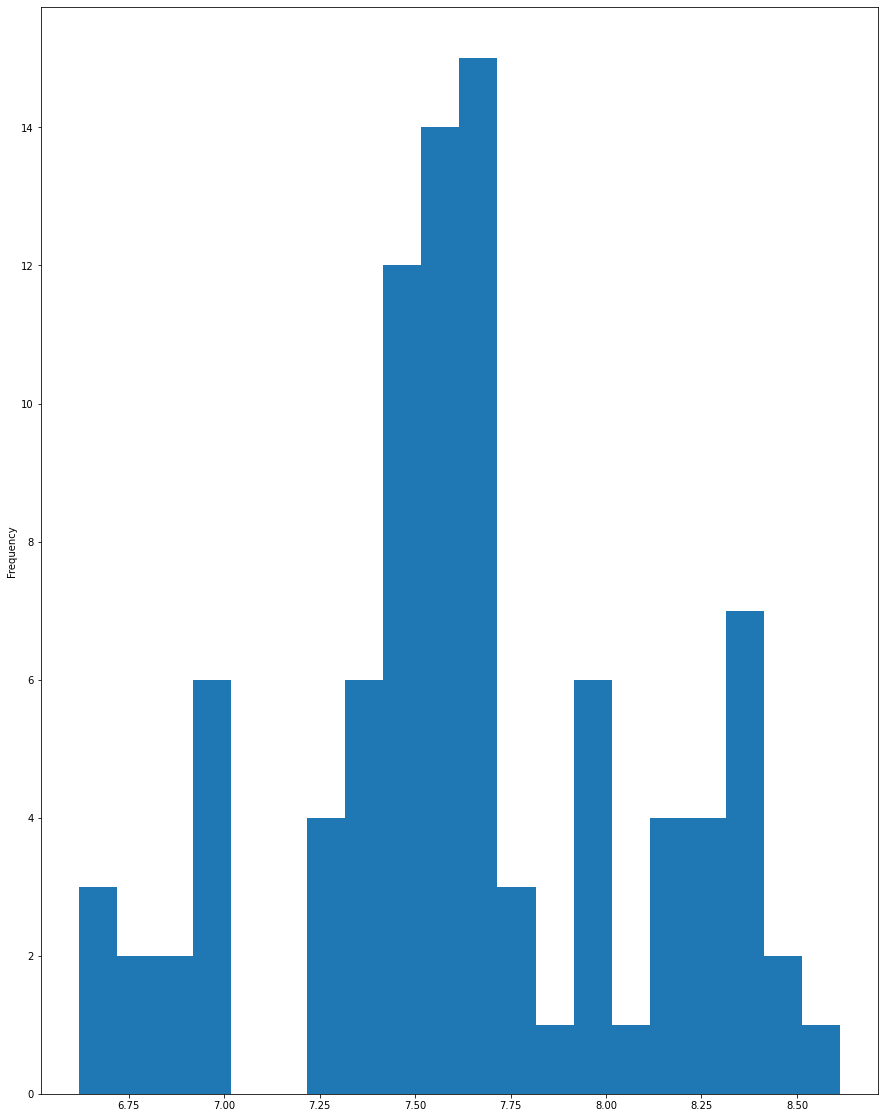

In [18]:
df2020_mum["log_modal_price"] = np.log(df2020_mum.modal_price)
df2020_mum.log_modal_price.plot(kind="hist", bins=20)

<AxesSubplot:xlabel='arrival_date'>

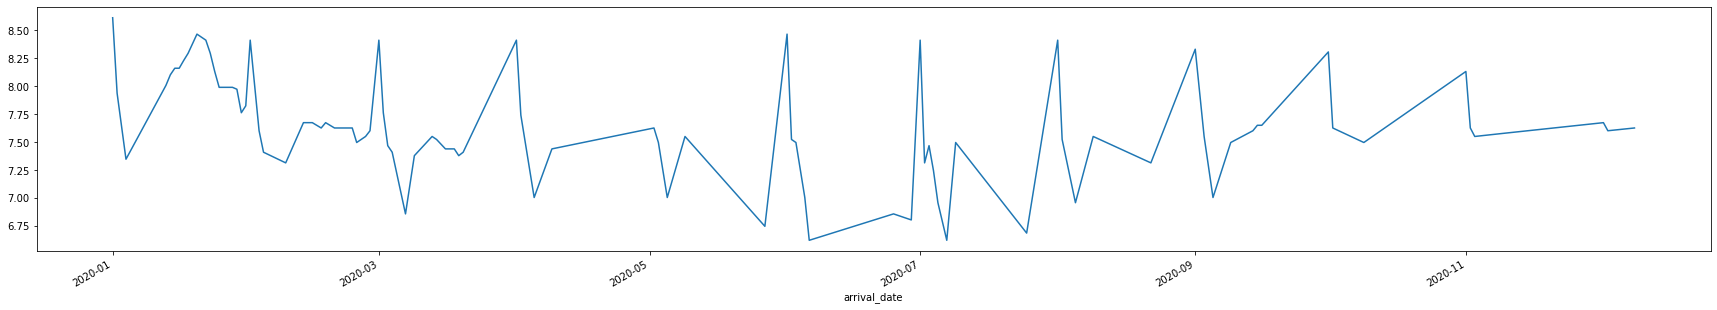

In [19]:
df2020_mum.log_modal_price.plot(figsize=[30,5])

# Building a time series model

In [20]:
df2020_mum.head()

,modal_price,log_modal_price
arrival_date,,
2020-01-01,5500,9
2020-01-02,2800,8
2020-01-04,1550,7
2020-01-13,3000,8
2020-01-14,3300,8


In [21]:
x=df2020_mum.index.copy()

In [22]:
df2020_mum.date = x

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [23]:
df2020_mum.head()

,modal_price,log_modal_price
arrival_date,,
2020-01-01,5500,9
2020-01-02,2800,8
2020-01-04,1550,7
2020-01-13,3000,8
2020-01-14,3300,8


In [24]:
# Converting the date into datetinme delta starting from 0
df2020_mum["timeindex"] = df2020_mum.date - df2020_mum.date.min()
df2020_mum.head()

,modal_price,log_modal_price,timeindex
arrival_date,,,
2020-01-01,5500,9,0 days
2020-01-02,2800,8,1 days
2020-01-04,1550,7,3 days
2020-01-13,3000,8,12 days
2020-01-14,3300,8,13 days


In [25]:
df2020_mum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2020-01-01 to 2020-12-09
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   modal_price      93 non-null     float64        
 1   log_modal_price  93 non-null     float64        
 2   timeindex        93 non-null     timedelta64[ns]
dtypes: float64(2), timedelta64[ns](1)
memory usage: 2.9 KB


In [26]:
# converting the timeindex into months using timedelta & then rounding it 
df2020_mum["timeindex"] = df2020_mum["timeindex"]/np.timedelta64(1,"D")
df2020_mum.head()

,modal_price,log_modal_price,timeindex
arrival_date,,,
2020-01-01,5500,9,0
2020-01-02,2800,8,1
2020-01-04,1550,7,3
2020-01-13,3000,8,12
2020-01-14,3300,8,13


In [27]:
df2020_mum["timeindex"] = df2020_mum["timeindex"].round(0).astype(int)
df2020_mum

,modal_price,log_modal_price,timeindex
arrival_date,,,
2020-01-01,5500,9,0
2020-01-02,2800,8,1
2020-01-04,1550,7,3
2020-01-13,3000,8,12
2020-01-14,3300,8,13
...,...,...,...
2020-11-03,1900,8,307
2020-11-09,1950,8,313
2020-12-02,2150,8,336


In [28]:
import statsmodels.formula.api as smf
linear_model = smf.ols('log_modal_price ~ timeindex', data = df2020_mum).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_modal_price   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     7.146
Date:                Tue, 31 May 2022   Prob (F-statistic):            0.00891
Time:                        11:53:48   Log-Likelihood:                -56.076
No. Observations:                  93   AIC:                             116.2
Df Residuals:                      91   BIC:                             121.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7900      0.075    104.377      0.000       7.642       7.938
timeindex     -0.0013      0.000     -2.673      0.009      -0.002      -0.000
==============================================================================
Omnibus:                        0.154   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.926   Jarque-Bera (JB):                0.327
Skew:                           0.056   Prob(JB):                        0.849
Kurtosis:                       2.732   Cond. No.                         255.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
linear_model_pred = linear_model.predict()
linear_model_pred

array([7.79000158, 7.78874109, 7.78622011, 7.77487567, 7.77361517,
       7.77235468, 7.77109419, 7.76983369, 7.7685732 , 7.76605221,
       7.76353123, 7.76227074, 7.76101024, 7.75974975, 7.75722876,
       7.75596827, 7.75470778, 7.75344728, 7.75218679, 7.7509263 ,
       7.74840531, 7.74714482, 7.74084235, 7.73580038, 7.73453989,
       7.73327939, 7.73075841, 7.72949791, 7.72697693, 7.72445594,
       7.72193495, 7.72067446, 7.71815347, 7.71689298, 7.71437199,
       7.7131115 , 7.71185101, 7.71059052, 7.70680904, 7.70428805,
       7.69924608, 7.69798558, 7.6954646 , 7.6942041 , 7.69294361,
       7.69168312, 7.69042262, 7.67529671, 7.67403621, 7.67025473,
       7.66521276, 7.63622142, 7.63496093, 7.63243994, 7.62739797,
       7.60470909, 7.59840662, 7.59714613, 7.59588564, 7.59336465,
       7.59210416, 7.56815479, 7.56311282, 7.56059183, 7.55933134,
       7.55807084, 7.55681035, 7.55554986, 7.55302887, 7.55050788,
       7.53033999, 7.52151654, 7.52025605, 7.51647457, 7.51143

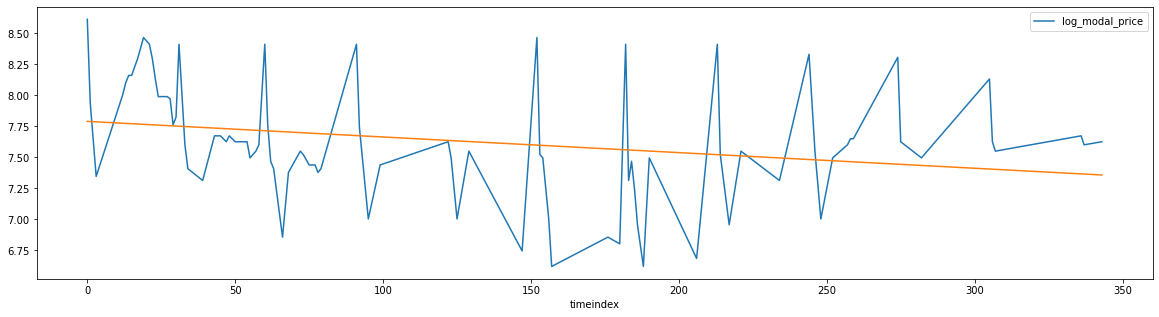

In [30]:
df2020_mum.plot(kind = "line", x="timeindex", y="log_modal_price", figsize=[20,5])
plt.plot(df2020_mum.timeindex, linear_model_pred)

<AxesSubplot:xlabel='arrival_date'>

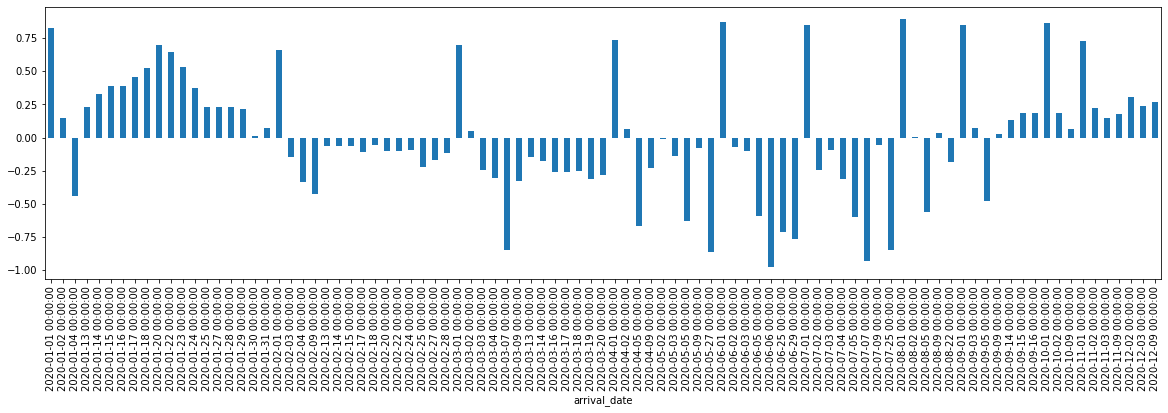

In [31]:
linear_model.resid.plot(kind="bar", figsize=[20,5])

# Evaluate the model using RMSE

In [32]:
df2020_mum["linear_price"] = np.exp(linear_model_pred)
df2020_mum.head()

,modal_price,log_modal_price,timeindex,linear_price
arrival_date,,,,
2020-01-01,5500,9,0,2416
2020-01-02,2800,8,1,2413
2020-01-04,1550,7,3,2407
2020-01-13,3000,8,12,2380
2020-01-14,3300,8,13,2377


In [33]:
df2020_mum_dummy= df2020_mum.set_index('timeindex')
df2020_mum_dummy.head()

,modal_price,log_modal_price,linear_price
timeindex,,,
0,5500,9,2416
1,2800,8,2413
3,1550,7,2407
12,3000,8,2380
13,3300,8,2377


<AxesSubplot:xlabel='timeindex'>

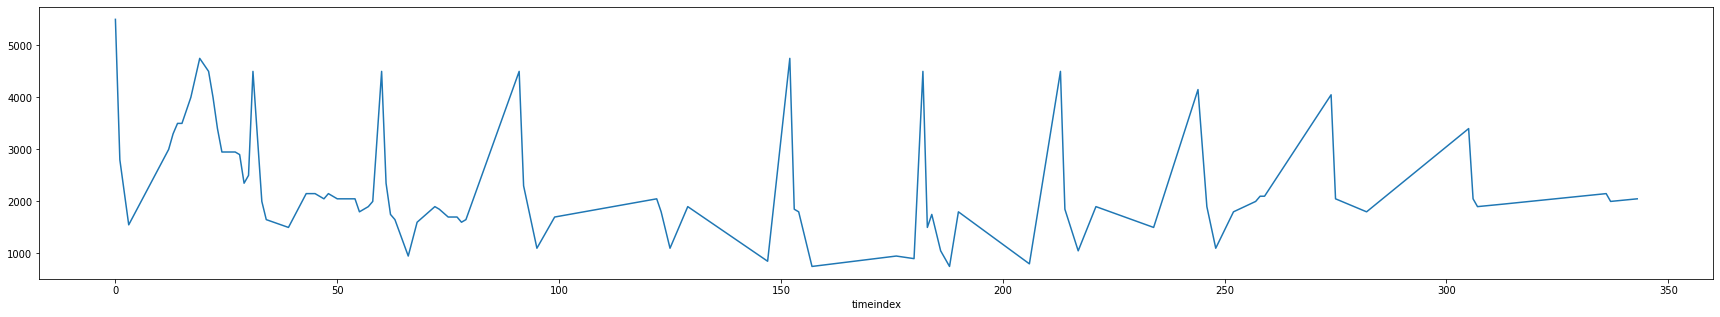

In [34]:
df2020_mum_dummy.modal_price.plot(figsize=[30,5])

<AxesSubplot:xlabel='timeindex'>

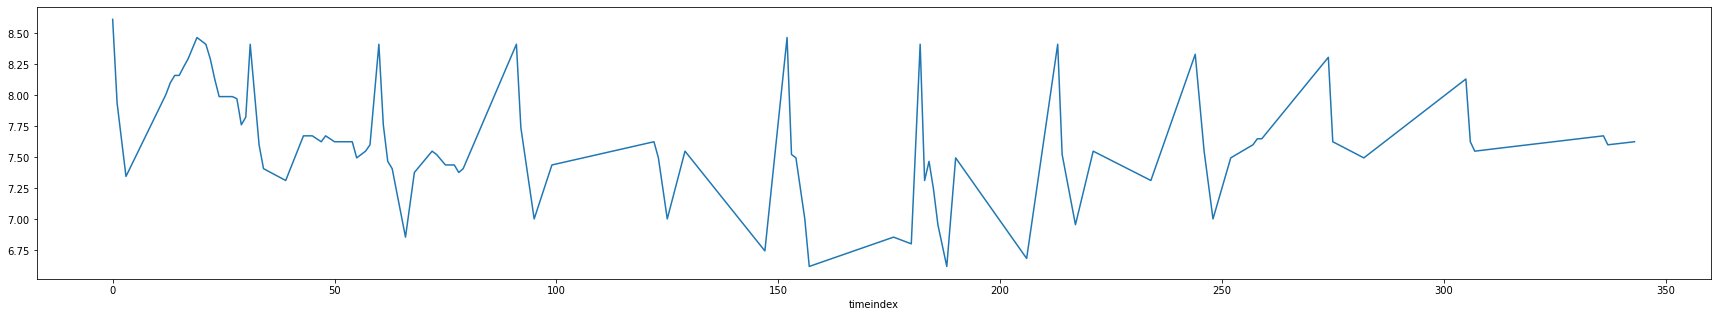

In [35]:
df2020_mum_dummy.log_modal_price.plot(figsize=[30,5])

In [36]:
def RMSE(actual, predicted):
    mse = (actual - predicted)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [37]:
linear_model_RMSE = RMSE(df2020_mum.modal_price, df2020_mum.linear_price)
linear_model_RMSE

1065.729288913768

# Plotting ACF & PACF Plots

In [38]:
df2020_mum.head()

,modal_price,log_modal_price,timeindex,linear_price
arrival_date,,,,
2020-01-01,5500,9,0,2416
2020-01-02,2800,8,1,2413
2020-01-04,1550,7,3,2407
2020-01-13,3000,8,12,2380
2020-01-14,3300,8,13,2377


## ACF & PACF for Modal_price

Adfuller test to check if the data is stationary, to perform ACF

In [39]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [40]:
adf_test(df2020_mum['modal_price'])

ADF Statistics: -7.582219344809563
p- value: 2.6633196234376075e-11
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


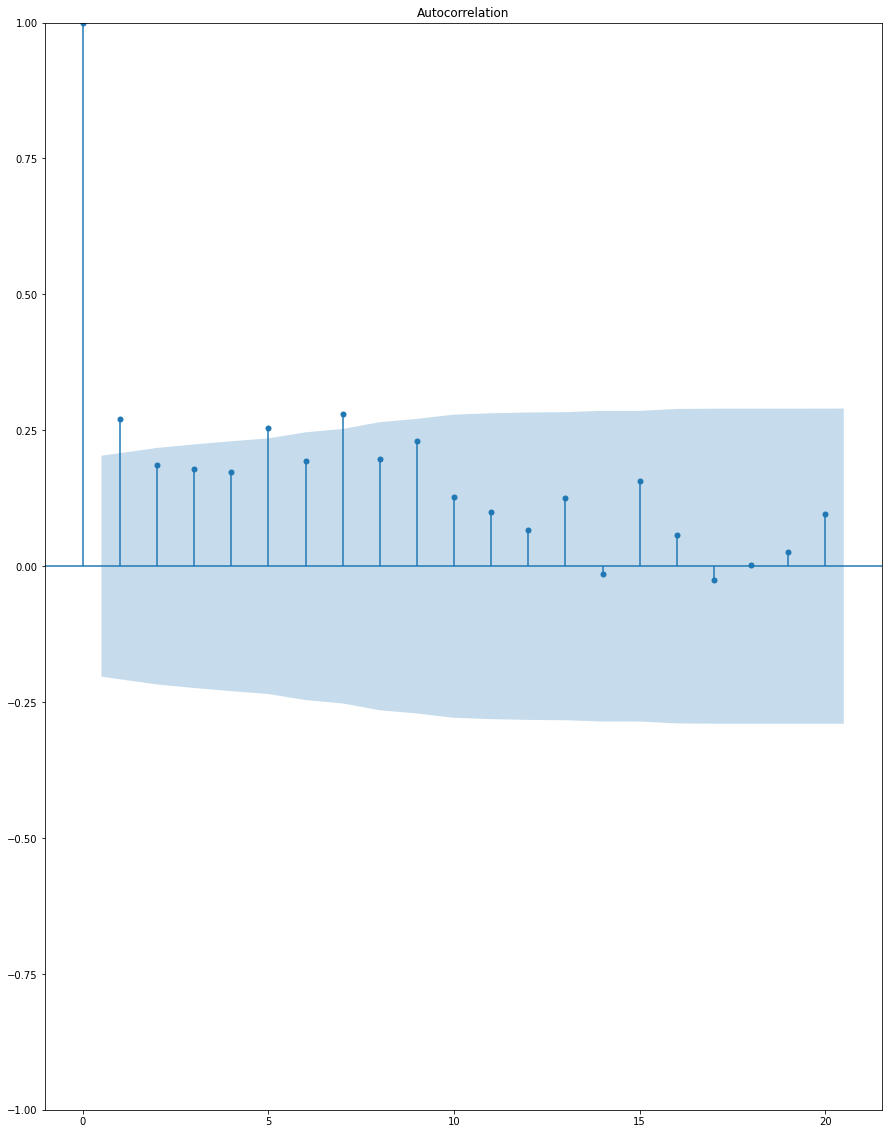

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(df2020_mum["modal_price"].dropna())

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


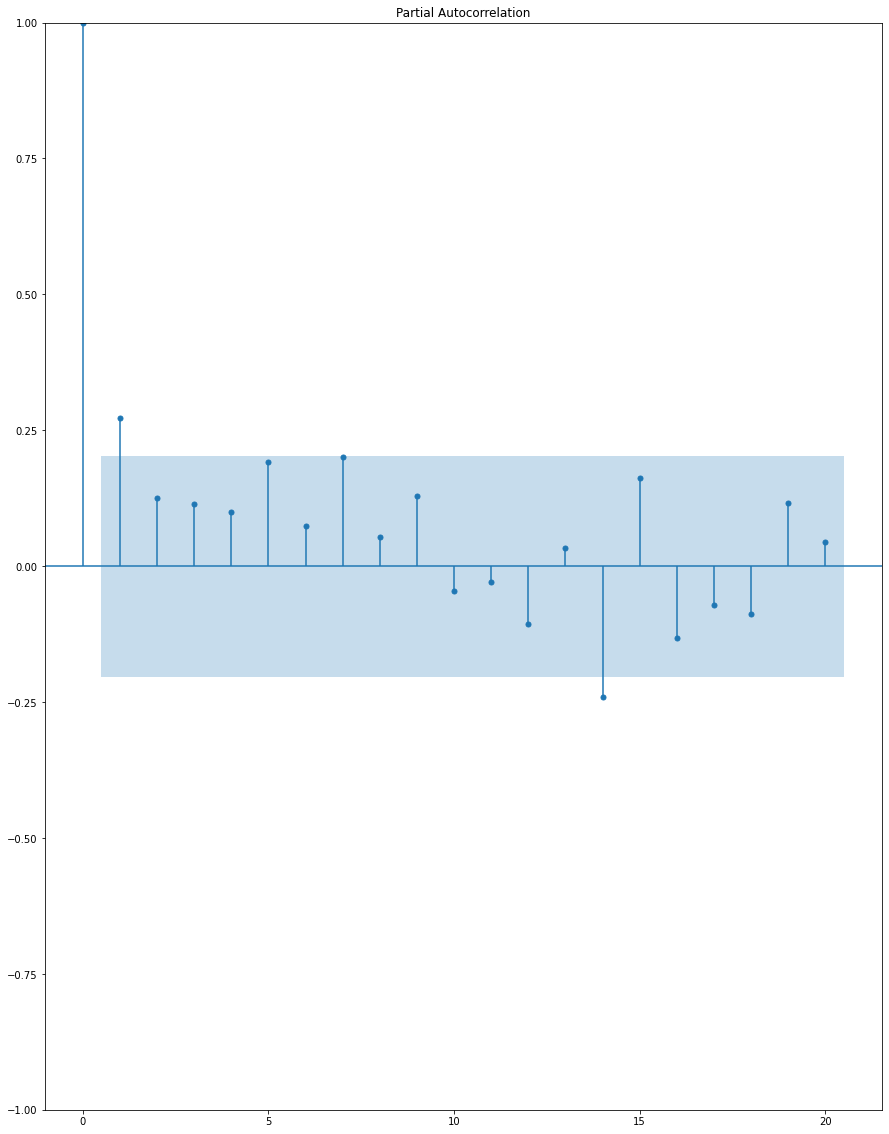

In [42]:
pacf = plot_pacf(df2020_mum["modal_price"].dropna())

## ACF & PACF for log_modal_price

In [43]:
adf_test(df2020_mum['log_modal_price'])

ADF Statistics: -7.043695451817989
p- value: 5.759151988343673e-10
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


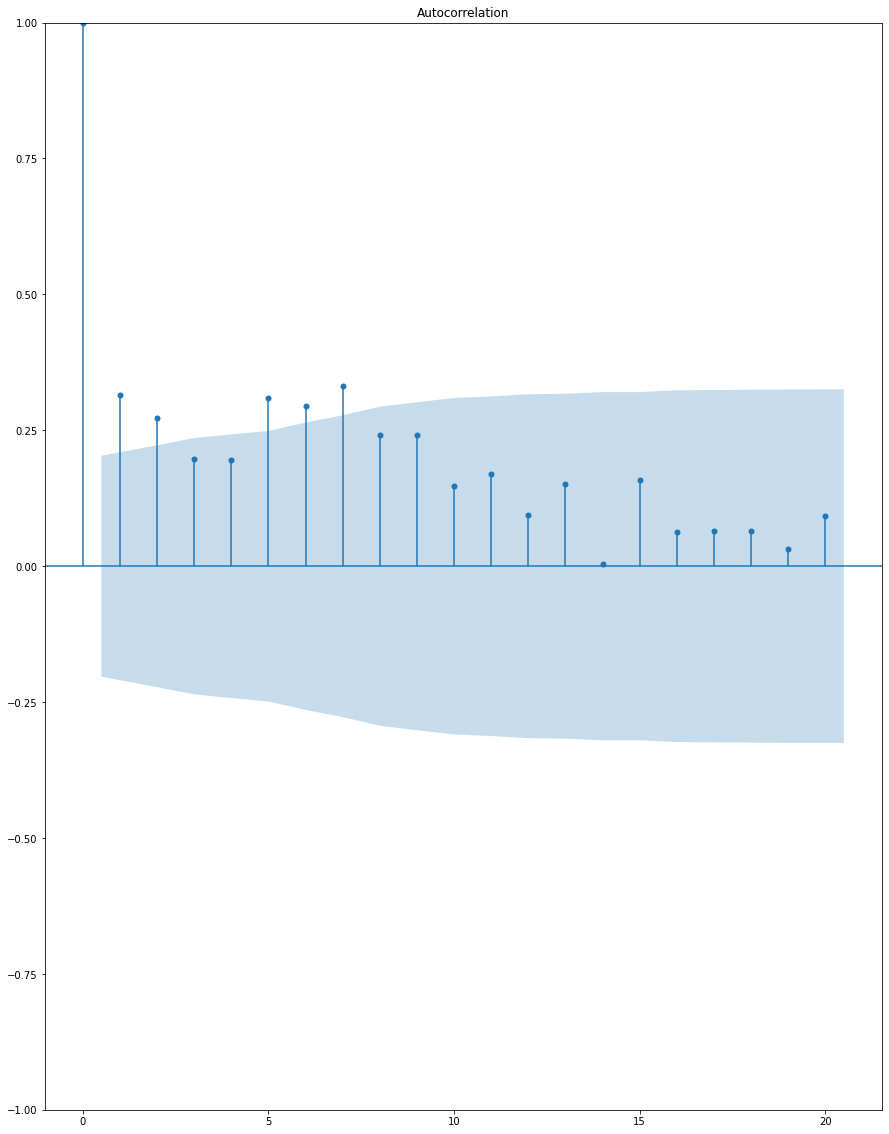

In [44]:
acf = plot_acf(df2020_mum["log_modal_price"].dropna())

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


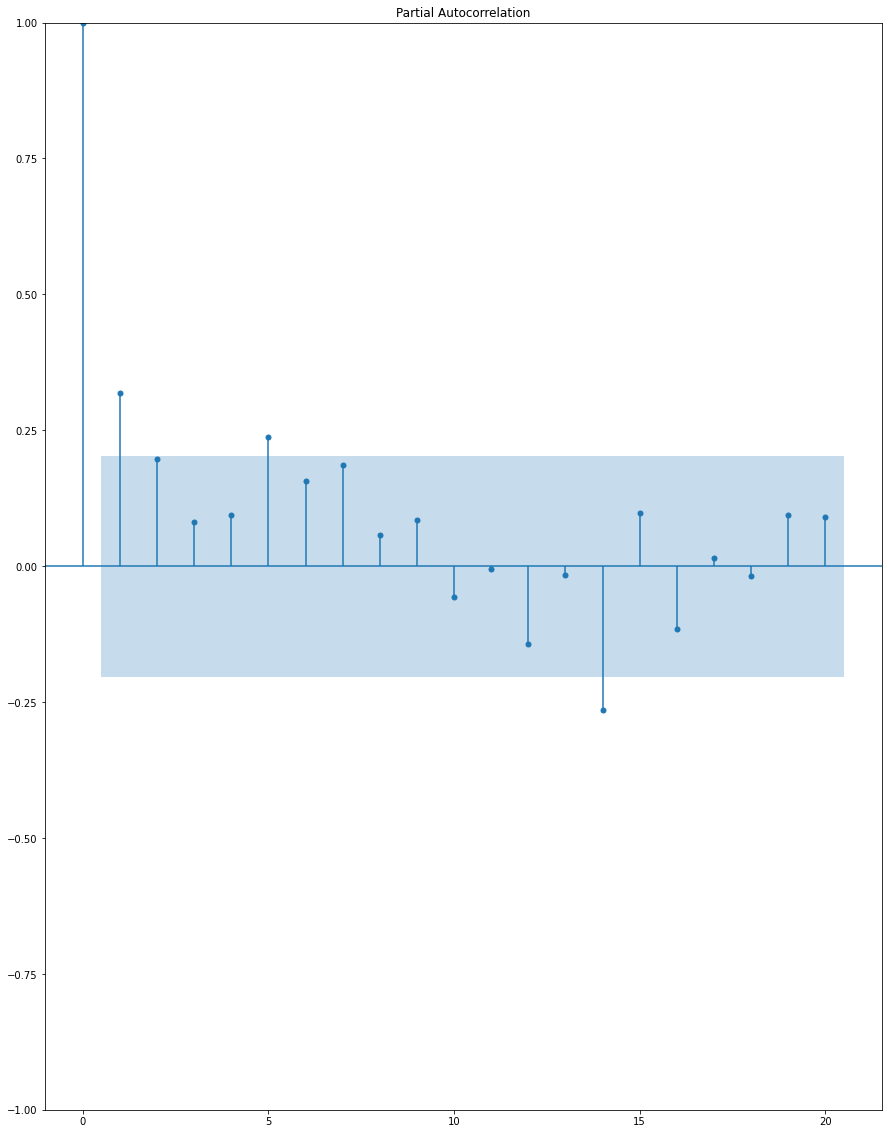

In [45]:
pacf = plot_pacf(df2020_mum["log_modal_price"].dropna())

# performing exponential smoothing using Holt-Winter’s technique

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [47]:
# Set the value of Alpha and define x as the time period
x = 12
alpha = 1/(2*x)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


<AxesSubplot:title={'center':'Holt Winters graph: Additive Trend and Multiplicative Trend'}, xlabel='arrival_date'>

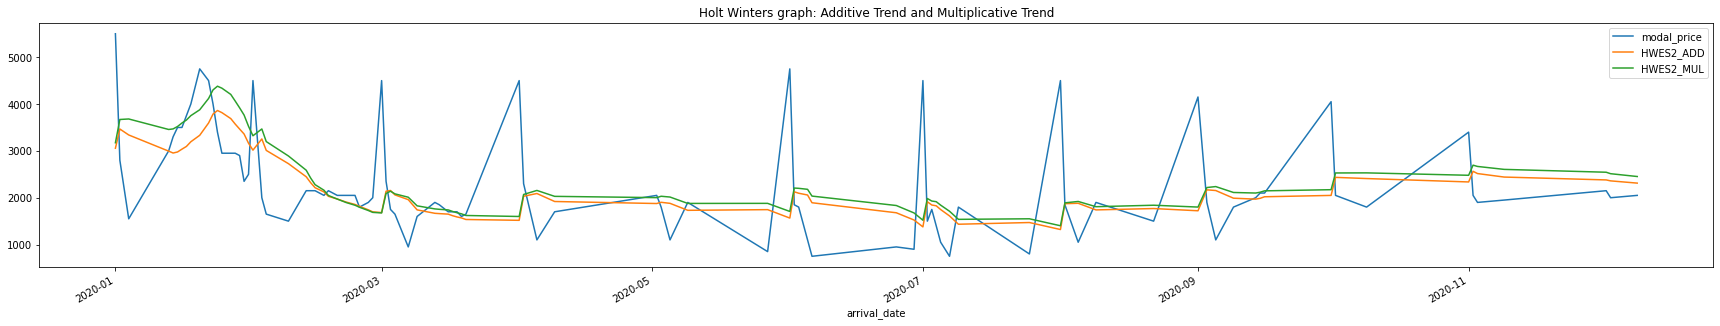

In [48]:
df2020_mum['HWES2_ADD'] = ExponentialSmoothing(df2020_mum['modal_price'],trend='add').fit().fittedvalues
df2020_mum['HWES2_MUL'] = ExponentialSmoothing(df2020_mum['modal_price'],trend='mul').fit().fittedvalues
df2020_mum[['modal_price','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters graph: Additive Trend and Multiplicative Trend',figsize=[30,5])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot:title={'center':'Holt Winters graph: Additive Trend and Multiplicative Trend'}, xlabel='arrival_date'>

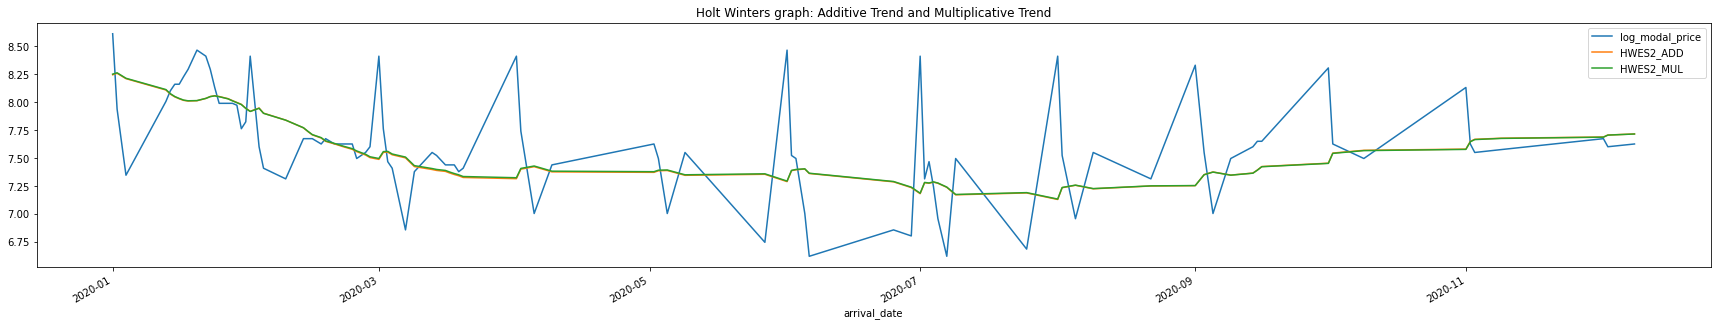

In [49]:
df2020_mum['HWES2_ADD'] = ExponentialSmoothing(df2020_mum['log_modal_price'],trend='add').fit().fittedvalues
df2020_mum['HWES2_MUL'] = ExponentialSmoothing(df2020_mum['log_modal_price'],trend='mul').fit().fittedvalues
df2020_mum[['log_modal_price','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters graph: Additive Trend and Multiplicative Trend',figsize=[30,5])

# Forecasting

In [50]:
df2020_mum.head(2)

,modal_price,log_modal_price,timeindex,linear_price,HWES2_ADD,HWES2_MUL
arrival_date,,,,,,
2020-01-01,5500,9,0,2416,8,8
2020-01-02,2800,8,1,2413,8,8


In [51]:
df2020_mum=df2020_mum.drop(['log_modal_price','timeindex','linear_price','HWES2_ADD','HWES2_MUL'],axis=1)

In [52]:
df2020_mum

,modal_price
arrival_date,
2020-01-01,5500
2020-01-02,2800
2020-01-04,1550
2020-01-13,3000
2020-01-14,3300
...,...
2020-11-03,1900
2020-11-09,1950
2020-12-02,2150


In [53]:
# Split into train and test set
train_df2020_mum =df2020_mum[:-25]
test_df2020_mum = df2020_mum[-25:]

In [54]:
model = ExponentialSmoothing(train_df2020_mum, seasonal_periods=25, trend='add', seasonal='mul')
fitted = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [55]:
sales_forecast = fitted.forecast(steps=25)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


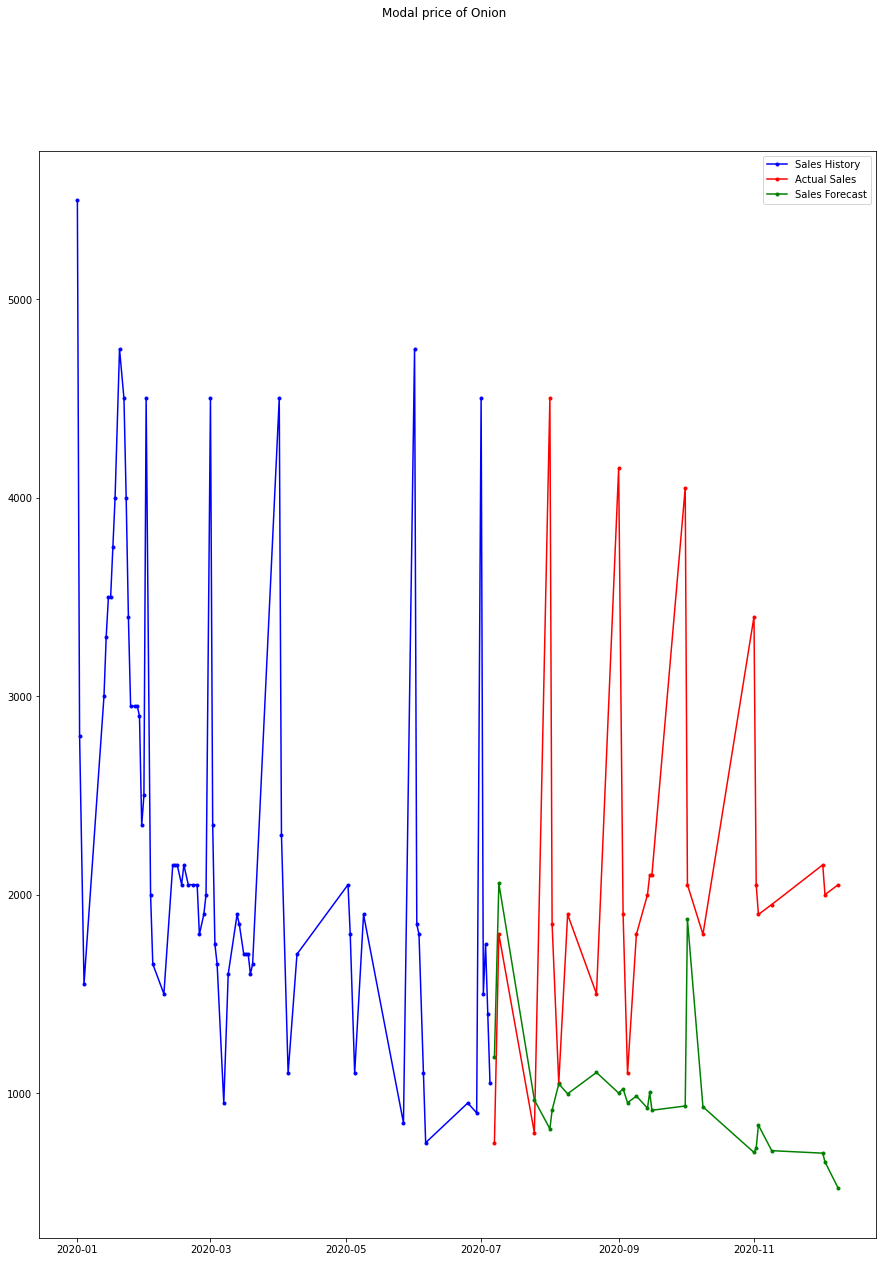

In [56]:
fig = plt.figure()
fig.suptitle('Modal price of Onion')
past, = plt.plot(train_df2020_mum.index, train_df2020_mum, 'b.-', label='Sales History')
future, = plt.plot(test_df2020_mum.index, test_df2020_mum, 'r.-', label='Actual Sales')
predicted_future, = plt.plot(test_df2020_mum.index, sales_forecast, 'g.-', label='Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()